# load sea ice data and generate a mask

In [1]:
import os, sys
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.plot import *

import xmitgcm as xm
from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=7, cores=7)
w = cluster.scale(jobs=20)
#w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.66:51818 Dashboard: http://10.148.1.66:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

## load data

AREA: SEAICE sea fractional ice area

HEFF: SEAICE mean sea ice thickness per grid cell

See xmitgcm [code](https://github.com/MITgcm/xmitgcm/blob/master/xmitgcm/variables.py)


In [37]:
fs = LocalFileSystem()

D = []
for v in ['AREA', 'HEFF']:
    store = llcreader.BaseStore(fs, base_path=bin_data_dir+'SI'+v.lower()+'/', 
                                shrunk=True, mask_path=mask_path)
    model = llcreader.LLC4320Model(store)
    D.append(model.get_dataset(varnames=[v], iter_step=24*144))
    
ds = xr.merge(D)

In [38]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 90, k_u: 90, time: 377)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    niter    (time) int64 10368 13824 17280 20736 ... 1302912 1306368 1309824
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-23
Data variables:
    AREA     (time, face, j, i) float32 dask.array<chunksize=(1, 3, 4320, 4320), meta=np.ndarray>
    HEFF     (time, face, j, i) float32 dask.array<chunksize=(1, 3, 4320, 4320), meta=np.ndarray>

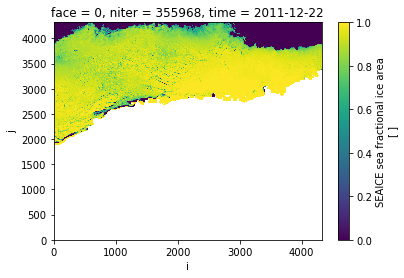

In [42]:
ds.isel(time=100,face=0)['AREA'].plot()

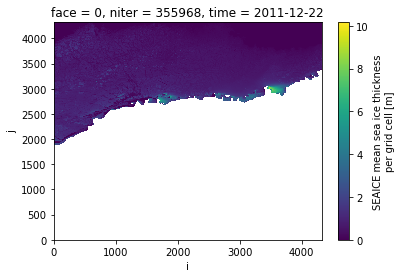

In [43]:
ds.isel(time=100,face=0)['HEFF'].plot()

In [44]:
ids = ds.where(ds.niter==79488, drop=True).persist()

(<Figure size 432x288 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaf4b2294d0>,
       dtype=object))

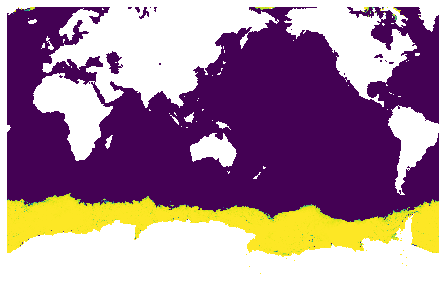

In [46]:
quick_llc_plot(ids['AREA'].isel(i=slice(0,None,4), j=slice(0,None,4)), 
               axis_off=True, vmax=1., add_colorbar=False)

--- 

# compute temporal average

In [47]:
ds_mean = ds.mean('time').persist()

(<Figure size 432x288 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aabffc87b10>,
       dtype=object))

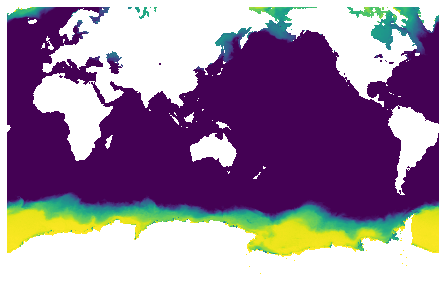

In [50]:
out = quick_llc_plot(ds_mean['AREA'].isel(i=slice(0,None,4), j=slice(0,None,4)), 
               axis_off=True, vmax=1., add_colorbar=False)

In [51]:
mask = xr.where(ds_mean['AREA']==0, 1., 0.)

(<Figure size 432x288 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aac0aaa4690>,
       dtype=object))

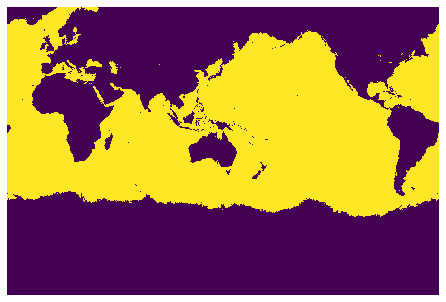

In [53]:
out = quick_llc_plot(mask.isel(i=slice(0,None,4), j=slice(0,None,4)), 
               axis_off=True, vmax=1., add_colorbar=False)

In [55]:
mask

<xarray.DataArray 'AREA' (face: 13, j: 4320, i: 4320)>
dask.array<where, shape=(13, 4320, 4320), dtype=float64, chunksize=(3, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319

In [57]:
(mask.chunk({'face':1})
     .to_dataset()
     .to_zarr(zarr_data_dir+'sea_ice_mask.zarr', mode='w')
)

---

In [58]:
# kill scheduler, workers
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
